In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import plotly
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import incf.countryutils
from incf.countryutils import transformations as transf
import os
import re

In [ ]:
plotly.offline.init_notebook_mode()
plotly.tools.set_credentials_file(username='azasibi', api_key='4ECEozhbsoIFu2rrgxEw')

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

In [4]:
saved_style_state = matplotlib.rcParams.copy()

1 // Retrieving and cleaning the data

In [5]:
#retrieve file from internet first time, then from os
if os.path.isfile("data2017.csv"):
    filepath = "data2017.csv"
    print "loading from file"
    data2017 = pd.read_csv(filepath)
else:
    filepath = "http://worldhappiness.report/wp-content/uploads/sites/2/2017/03/online-data-chapter-2-whr-2017.xlsx"
    print "loading from the internet"
    xlsx_file = pd.read_excel(filepath, 'Figure2.2 WHR 2017')
    data2017 = xlsx_file.to_csv('data2017.csv')
    data2017 = pd.read_csv('data2017.csv')

print "done"

loading from file
done


In [6]:
data2017.head() #top 5 rows

,Unnamed: 0,Country,Happiness score,Whisker-high,Whisker-low,Explained by: GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia (1.85) + residual
0,0,Norway,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,1,Denmark,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,2,Iceland,7.504,7.622030,7.385970,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,3,Switzerland,7.494,7.561772,7.426227,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,4,Finland,7.469,7.527542,7.410458,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182


In [7]:
#remove unecessary column
data2017 = data2017.drop(['Unnamed: 0'], axis=1) 
data2017.head()

,Country,Happiness score,Whisker-high,Whisker-low,Explained by: GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia (1.85) + residual
0,Norway,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,Denmark,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,Iceland,7.504,7.622030,7.385970,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,Switzerland,7.494,7.561772,7.426227,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,Finland,7.469,7.527542,7.410458,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182


In [8]:
#add colomn of countries rank
data2017.insert(0, 'rank', range(0, len(data2017)))
data2017.head()

,rank,Country,Happiness score,Whisker-high,Whisker-low,Explained by: GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia (1.85) + residual
0,0,Norway,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,1,Denmark,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,2,Iceland,7.504,7.622030,7.385970,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,3,Switzerland,7.494,7.561772,7.426227,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,4,Finland,7.469,7.527542,7.410458,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182


In [9]:
#Create column of continents the countries are from
data2017['continent'] = data2017['Country'] #create duplicate column of countries

for x in range(0, len(data2017)):
    try: #transfer country to its corresponding continent value
        data2017['continent'].iloc[x] = transf.cn_to_ctn(data2017['Country'].iloc[x])
    except Exception as e: #if unable to find country in library, print the country and continue
        print(data2017['Country'].iloc[x])
        continue

/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:141: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



United States
United Kingdom
Taiwan Province of China
Slovakia
Russia
South Korea
North Cyprus
Libya
Hong Kong S.A.R., China
Kosovo
Kyrgyzstan
Palestinian Territories
Congo (Brazzaville)
Congo (Kinshasa)
Ivory Coast
South Sudan
Syria


In [10]:
#for values not determined, replace manually
data2017['continent'].replace('United States', 'North America', inplace = True)
data2017['continent'].replace('United Kingdom', 'Europe', inplace = True)
data2017['continent'].replace('Taiwan Province of China', 'Asia', inplace = True)
data2017['continent'].replace('Slovakia', 'Europe', inplace = True)
data2017['continent'].replace('Russia', 'Europe', inplace = True)
data2017['continent'].replace('South Korea', 'Asia', inplace = True)
data2017['continent'].replace('North Cyprus', 'Europe', inplace = True)
data2017['continent'].replace('Libya', 'Africa', inplace = True)
data2017['continent'].replace('Hong Kong S.A.R., China', 'Asia', inplace = True)
data2017['continent'].replace('Kosovo', 'Europe', inplace = True)
data2017['continent'].replace('Kyrgyzstan', 'Asia', inplace = True)
data2017['continent'].replace('Palestinian Territories', 'Asia', inplace = True)
data2017['continent'].replace('Congo (Brazzaville)', 'Africa', inplace = True)
data2017['continent'].replace('Congo (Kinshasa)', 'Africa', inplace = True)
data2017['continent'].replace('Ivory Coast', 'Africa', inplace = True)
data2017['continent'].replace('South Sudan', 'Africa', inplace = True)
data2017['continent'].replace('Syria', 'Asia', inplace = True)
data2017.head()

,rank,Country,Happiness score,Whisker-high,Whisker-low,Explained by: GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia (1.85) + residual,continent
0,0,Norway,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027,Europe
1,1,Denmark,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707,Europe
2,2,Iceland,7.504,7.622030,7.385970,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715,Europe
3,3,Switzerland,7.494,7.561772,7.426227,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716,Europe
4,4,Finland,7.469,7.527542,7.410458,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182,Europe


In [11]:
#change column tiles for ease of use throughout code
data2017 = data2017.rename(columns= {'Happiness score' : 'happy'})
data2017 = data2017.rename(columns= {'Explained by: GDP per capita' : 'GDP'})
data2017 = data2017.rename(columns= {'Explained by: Social support' : 'social'})
data2017 = data2017.rename(columns= {'Explained by: Healthy life expectancy' : 'lifeExp'})
data2017 = data2017.rename(columns= {'Explained by: Freedom to make life choices' : 'freedom'})
data2017 = data2017.rename(columns= {'Explained by: Generosity' : 'generosity'})
data2017 = data2017.rename(columns= {'Explained by: Perceptions of corruption' : 'corruption'})
data2017 = data2017.rename(columns= {'Dystopia (1.85) + residual' : 'dystopia'})
data2017 = data2017.rename(columns= {'Explained by: Generosity' : 'generosity'})
data2017.head() 

,rank,Country,happy,Whisker-high,Whisker-low,GDP,social,lifeExp,freedom,generosity,corruption,dystopia,continent
0,0,Norway,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027,Europe
1,1,Denmark,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707,Europe
2,2,Iceland,7.504,7.622030,7.385970,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715,Europe
3,3,Switzerland,7.494,7.561772,7.426227,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716,Europe
4,4,Finland,7.469,7.527542,7.410458,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182,Europe


In [37]:
trace1 = go.Scatter(
     x = data2017['Country'],
     y = data2017['happy'],
     mode = 'markers',
     marker = dict(
         size = '16',
         color = data2017['rank'],
         showscale = True
     )
)

layout = go.Layout(
    title = 'Happiness ranking of all Countries',
    xaxis = dict(
        title = 'Country'
    ),
    yaxis = dict(
        title = 'Happiness Score'
    )
)

data = [trace1]

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename = 'scatter-plot-with-colorscale')

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~azasibi/0 or inside your plot.ly account where it is named 'scatter-plot-with-colorscale'


/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:545: UserWarning:

No labelled objects found. Use label='...' kwarg on individual plots.



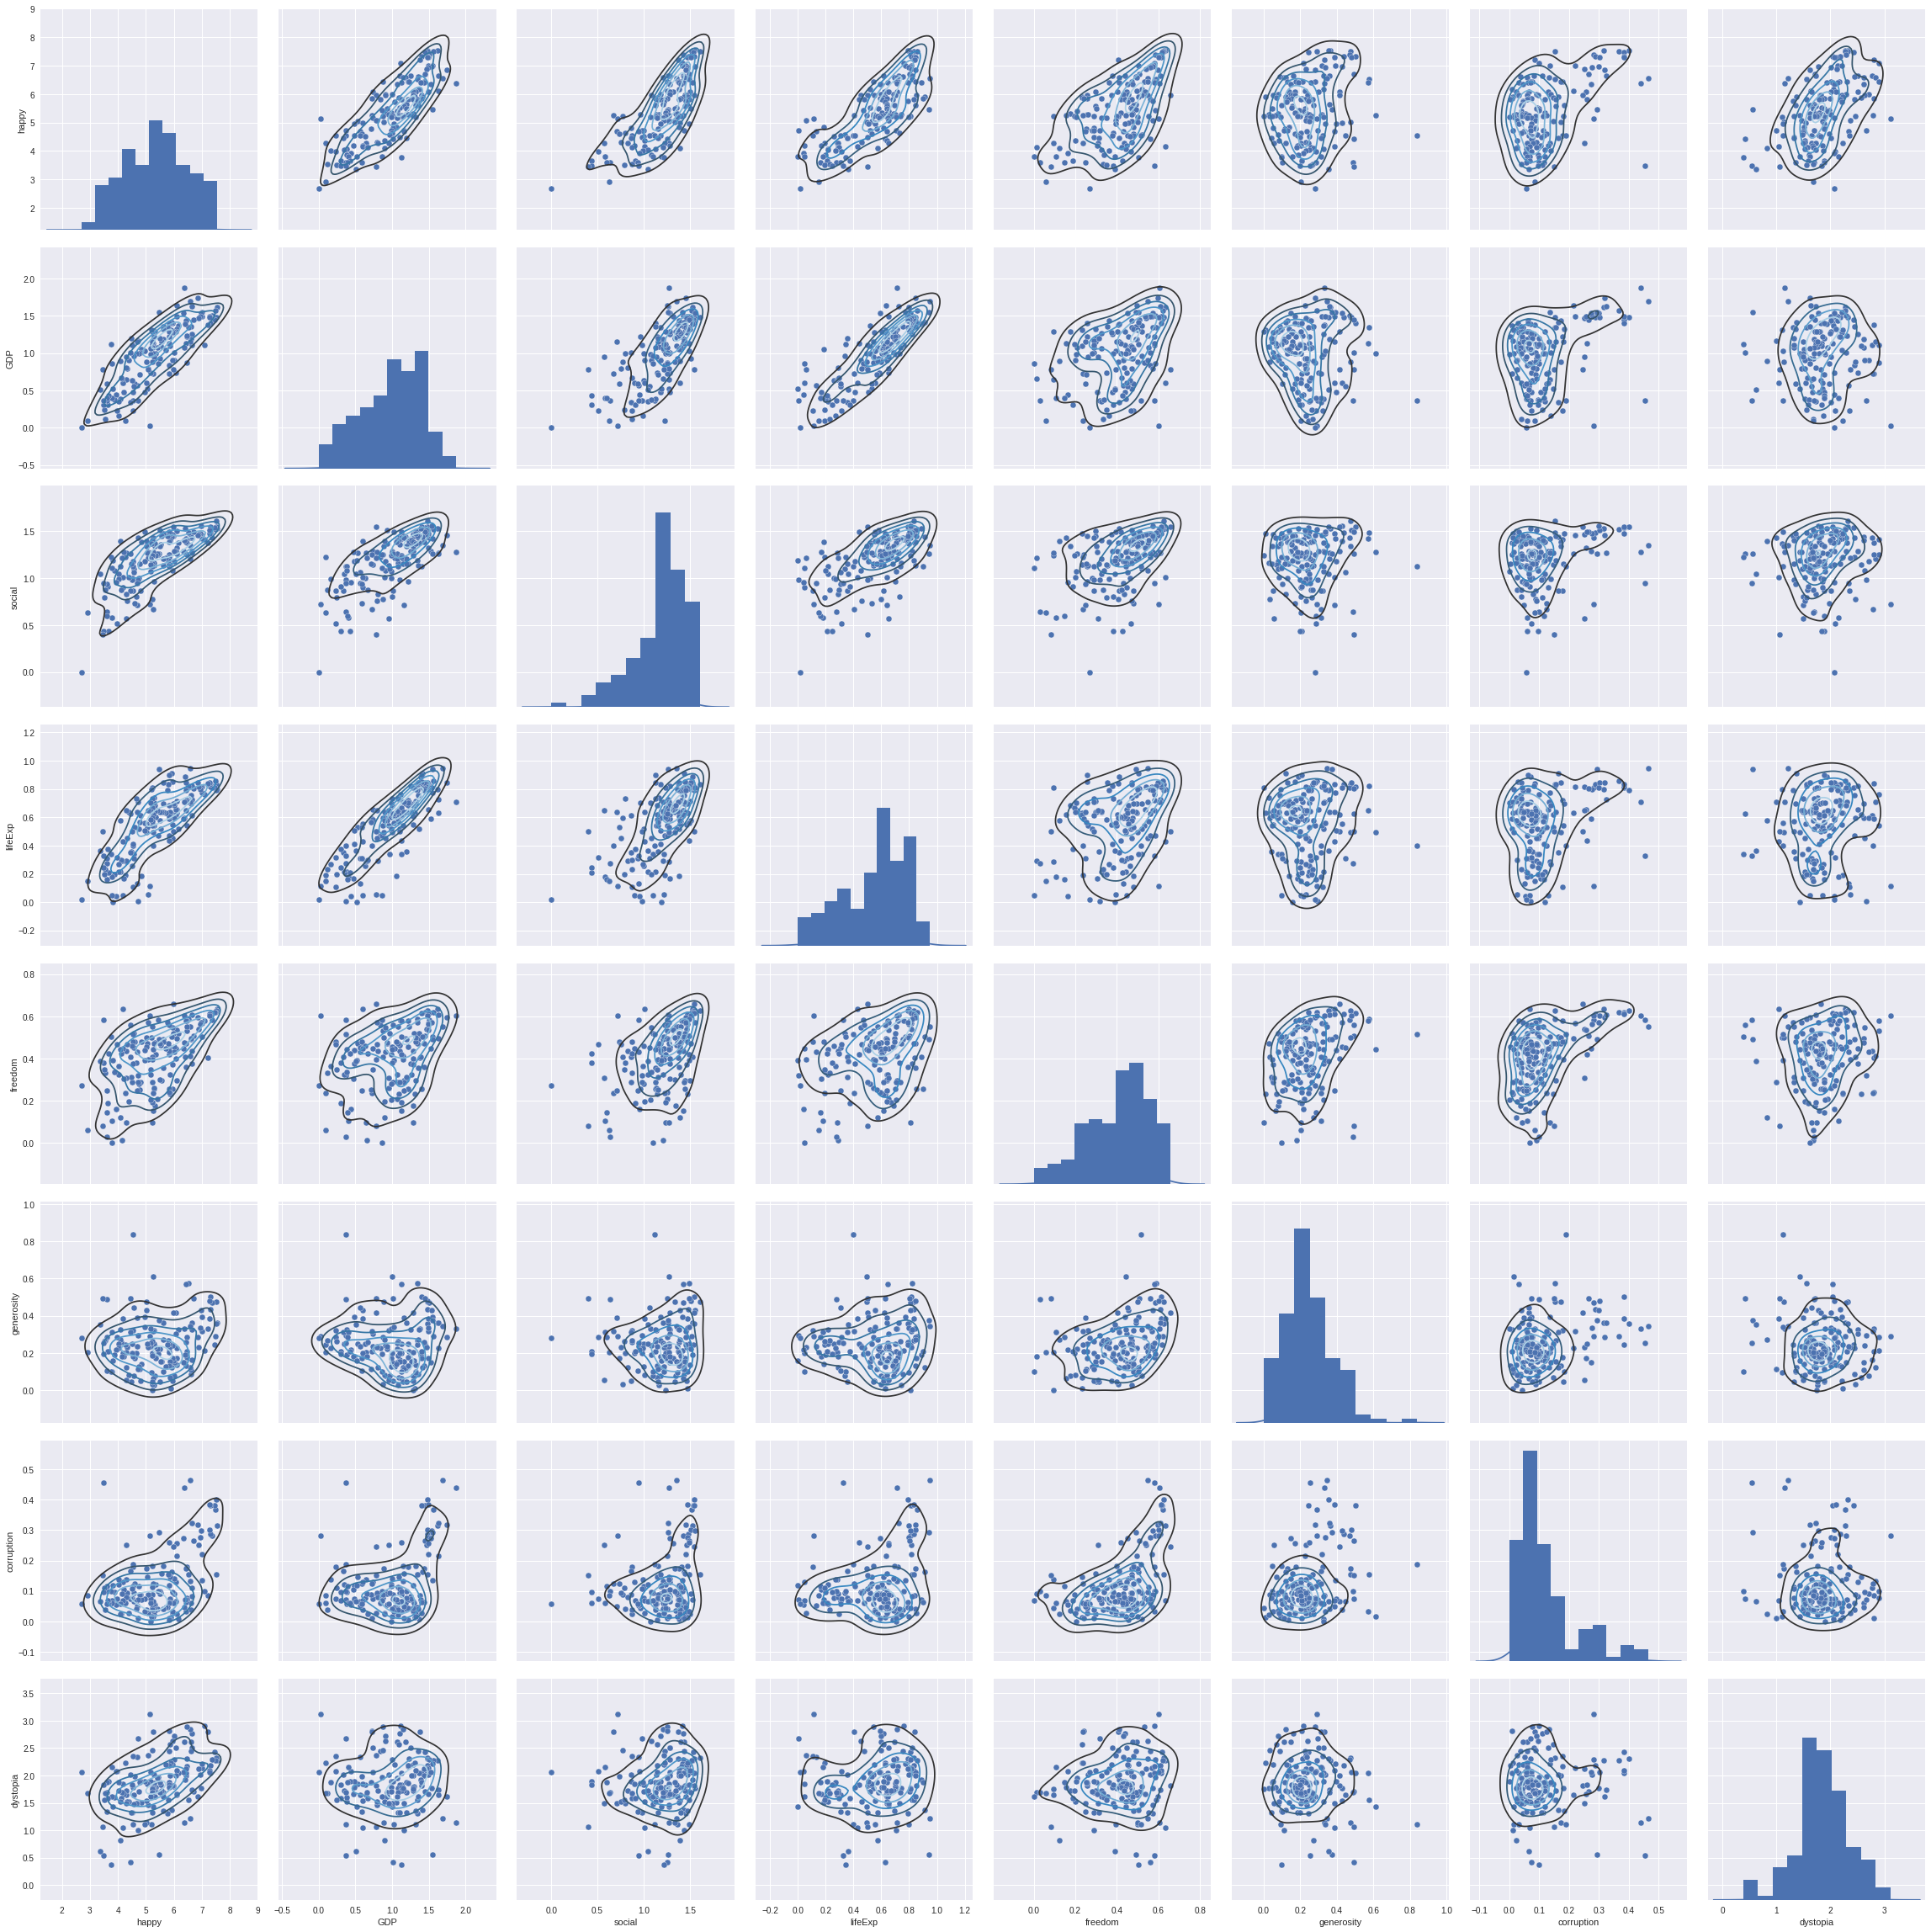

In [13]:
#observe any correlations from several categories
g = sns.pairplot(data2017[['happy', 'GDP', 'social', 'lifeExp', 'freedom', 
                           'generosity', 'corruption', 'dystopia']], size = 4)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, cmap = "Blues_d", n_levels = 6)

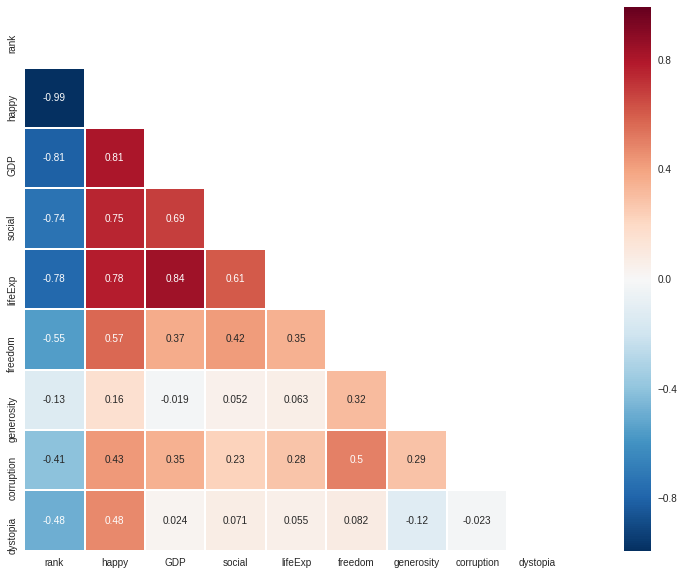

In [14]:
#create correlation map for visual/quantifiable relationships
corr = data2017.drop(['Whisker-high', 'Whisker-low', 'continent'], axis=1) #drop values not to be included
corrmap = corr.corr()

mask = np.zeros_like(corrmap)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
        ax = sns.heatmap(corrmap, linewidths=1, annot=True, mask=mask, vmax=0.3, square=True)

In [15]:
trace1 = go.Scatter(
     x = data2017['Country'],
     y = data2017['GDP'],
     mode = 'markers',
     marker = dict(
         size = '16',
         color = data2017['rank'],
         showscale = True
     )
)


layout = go.Layout(
    title = 'Happiness vs the economy (GDP)',
    xaxis = dict(
        title = 'Happiness Score'
    ),
    yaxis = dict(
        title = 'GDP'
    )
)

data = [trace1]

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename = 'scatter-plot-with-colorscale')

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~azasibi/0 or inside your plot.ly account where it is named 'scatter-plot-with-colorscale'


<function matplotlib.pyplot.xticks>

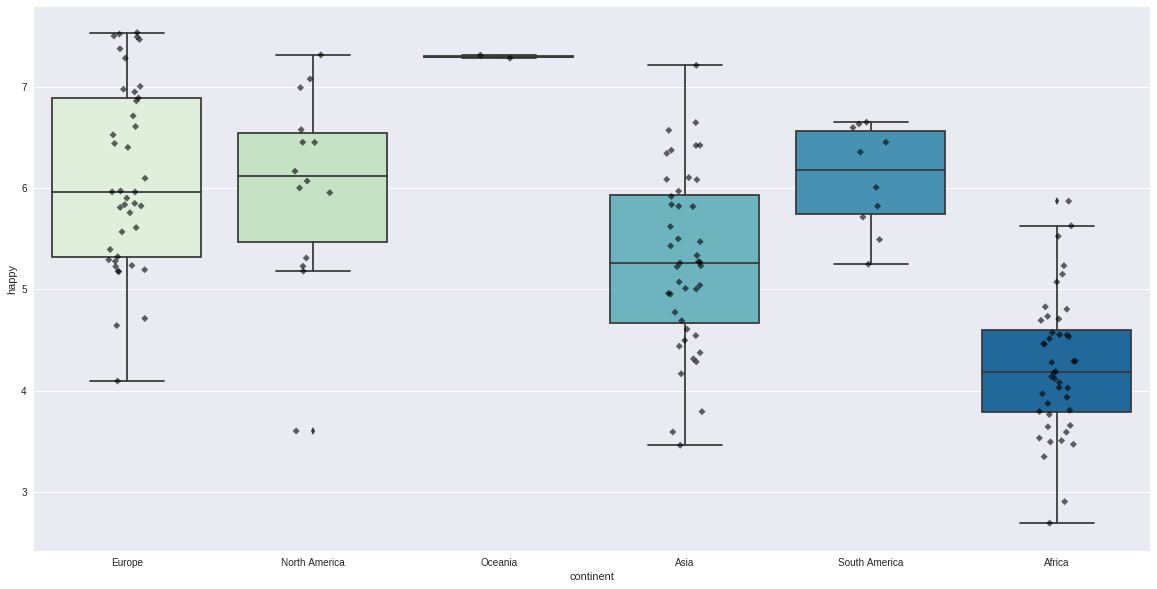

In [16]:
#scatterplot of happiness by continent
g = sns.stripplot(x='continent', y = 'happy', data = data2017, size=5, marker="D", alpha =.6, jitter = True, color = "black")
#box plot of happiness by continent
sns.set_style("whitegrid")
g = sns.boxplot(x = 'continent', y = 'happy', data = data2017, palette = "GnBu") 
plt.xticks

In [17]:
#create choropleth map of global happiness
data = dict(type = 'choropleth', 
           locations = data2017['Country'],
           locationmode = 'country names',
           z = data2017['happy'],
           colorscale = [[0,"rgb(242,240,247)"], [0.35, "rgb(218, 218, 235)"], [0.6,"rgb(188, 189, 220)"], 
                        [0.7, "rgb(158, 154, 200)"], [1, "rgb(84, 39, 143)"]],
           text = data2017['Country'],
           autocolorscale = False,
           colorbar = {'title':'Happiness'})

layout = dict(title = 'Global Happiness', 
                geo = dict(showframe = False, 
                       projection = {'type': 'Mercator'}))

globalMap = go.Figure(data = [data], layout=layout)
iplot(globalMap)

In [18]:
#open 2015 data from internet or file
if os.path.isfile("2015.csv"):
    filepath = "2015.csv"
    print "loading from file"
    data2015 = pd.read_csv(filepath)
else:
    filepath = "https://raw.githubusercontent.com/dbisazza/code1161base/master/week6/2015.csv"
    print "loading from the internet"
    data2015 = pd.read_csv(filepath)
    data2015.to_csv('2015.csv')

print "done"

loading from file
done


In [19]:
#open 2016 data from internet or file
if os.path.isfile("2016.csv"):
    filepath = "2016.csv"
    print "loading from file"
    data2016 = pd.read_csv(filepath)
    
else:
    filepath = "https://raw.githubusercontent.com/dbisazza/code1161base/master/week6/2016.csv"
    print "loading from the internet"
    data2016 = pd.read_csv(filepath)
    data2016.to_csv('2016.csv')

print "done"

loading from file
done


In [20]:
data2015.head()

,Unnamed: 0,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,0,Switzerland,Western Europe,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738
1,1,Iceland,Western Europe,2,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201
2,2,Denmark,Western Europe,3,7.527,0.03328,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204
3,3,Norway,Western Europe,4,7.522,0.03880,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531
4,4,Canada,North America,5,7.427,0.03553,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176


In [21]:
data2016.head()

,Unnamed: 0,Country,Region,Happiness Rank,Happiness Score,Lower Confidence Interval,Upper Confidence Interval,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,0,Denmark,Western Europe,1,7.526,7.460,7.592,1.44178,1.16374,0.79504,0.57941,0.44453,0.36171,2.73939
1,1,Switzerland,Western Europe,2,7.509,7.428,7.590,1.52733,1.14524,0.86303,0.58557,0.41203,0.28083,2.69463
2,2,Iceland,Western Europe,3,7.501,7.333,7.669,1.42666,1.18326,0.86733,0.56624,0.14975,0.47678,2.83137
3,3,Norway,Western Europe,4,7.498,7.421,7.575,1.57744,1.12690,0.79579,0.59609,0.35776,0.37895,2.66465
4,4,Finland,Western Europe,5,7.413,7.351,7.475,1.40598,1.13464,0.81091,0.57104,0.41004,0.25492,2.82596


In [22]:
#change column tiles for ease of use throughout code and consistency 
data2015 = data2015.rename(columns= {'Happiness Score' : 'happy'})
data2015 = data2015.rename(columns= {'Happiness Rank' : 'rank'})
data2015 = data2015.rename(columns= {'Economy (GDP per Capita)' : 'GDP'})
data2015 = data2015.rename(columns= {'Family' : 'social'})
data2015 = data2015.rename(columns= {'Health (Life Expectancy)' : 'lifeExp'})
data2015 = data2015.rename(columns= {'Freedom' : 'freedom'})
data2015 = data2015.rename(columns= {'Generosity' : 'generosity'})
data2015 = data2015.rename(columns= {'Trust (Government Corruption)' : 'corruption'})
data2015 = data2015.rename(columns= {'Dystopia Residual' : 'dystopia'})
data2015.head()

,Unnamed: 0,Country,Region,rank,happy,Standard Error,GDP,social,lifeExp,freedom,corruption,generosity,dystopia
0,0,Switzerland,Western Europe,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738
1,1,Iceland,Western Europe,2,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201
2,2,Denmark,Western Europe,3,7.527,0.03328,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204
3,3,Norway,Western Europe,4,7.522,0.03880,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531
4,4,Canada,North America,5,7.427,0.03553,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176


In [23]:
#change column tiles for ease of use throughout code and consistency
data2016 = data2016.rename(columns= {'Happiness Score' : 'happy'})
data2016 = data2016.rename(columns= {'Happiness Rank' : 'rank'})
data2016 = data2016.rename(columns= {'Economy (GDP per Capita)' : 'GDP'})
data2016 = data2016.rename(columns= {'Family' : 'social'})
data2016 = data2016.rename(columns= {'Health (Life Expectancy)' : 'lifeExp'})
data2016 = data2016.rename(columns= {'Freedom' : 'freedom'})
data2016 = data2016.rename(columns= {'Generosity' : 'generosity'})
data2016 = data2016.rename(columns= {'Trust (Government Corruption)' : 'corruption'})
data2016 = data2016.rename(columns= {'Dystopia Residual' : 'dystopia'})
data2016.head()

,Unnamed: 0,Country,Region,rank,happy,Lower Confidence Interval,Upper Confidence Interval,GDP,social,lifeExp,freedom,corruption,generosity,dystopia
0,0,Denmark,Western Europe,1,7.526,7.460,7.592,1.44178,1.16374,0.79504,0.57941,0.44453,0.36171,2.73939
1,1,Switzerland,Western Europe,2,7.509,7.428,7.590,1.52733,1.14524,0.86303,0.58557,0.41203,0.28083,2.69463
2,2,Iceland,Western Europe,3,7.501,7.333,7.669,1.42666,1.18326,0.86733,0.56624,0.14975,0.47678,2.83137
3,3,Norway,Western Europe,4,7.498,7.421,7.575,1.57744,1.12690,0.79579,0.59609,0.35776,0.37895,2.66465
4,4,Finland,Western Europe,5,7.413,7.351,7.475,1.40598,1.13464,0.81091,0.57104,0.41004,0.25492,2.82596


In [24]:
#remove unecessary columns if sourced from file
data2015 = data2015.drop(['Unnamed: 0'], axis=1) 
data2016 = data2016.drop(['Unnamed: 0'], axis=1) 

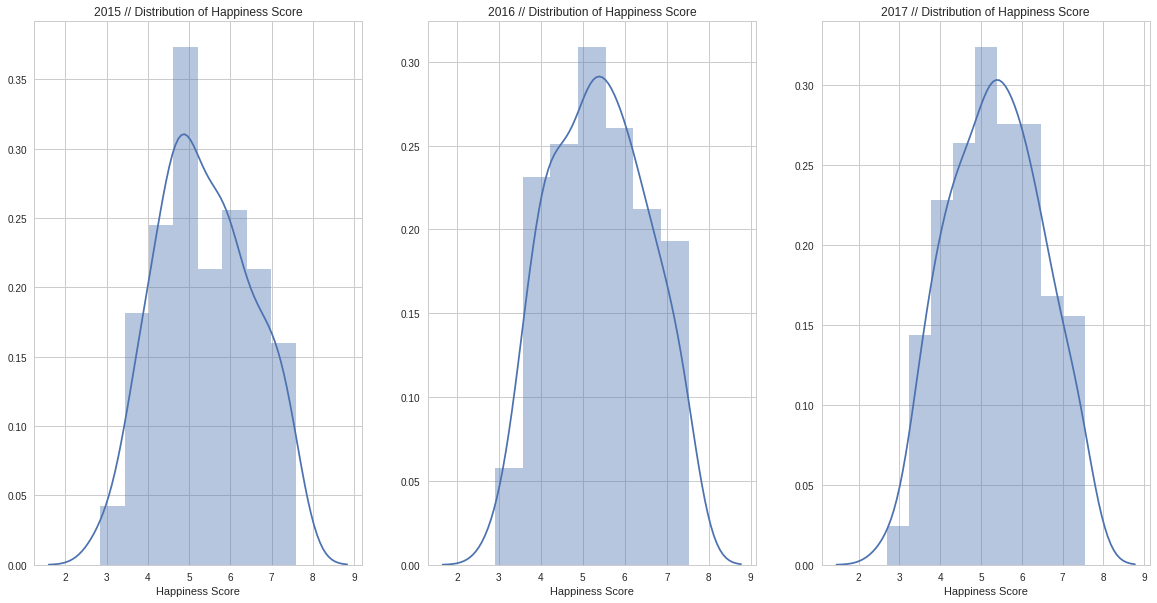

In [25]:
#distribution plot for 2015-2017
fig,axes = plt.subplots(nrows = 1, ncols = 3)
dis = sns.distplot(data2015['happy'], kde=True,ax=axes[0])
dis.set_xlabel('Happiness Score')
dis = sns.distplot(data2016['happy'], kde=True,ax=axes[1])
dis.set_xlabel('Happiness Score')
dis = sns.distplot(data2017['happy'], kde=True,ax=axes[2])
dis.set_xlabel('Happiness Score')
axes[0].set_title("2015 // Distribution of Happiness Score")
axes[1].set_title("2016 // Distribution of Happiness Score")
axes[2].set_title("2017 // Distribution of Happiness Score")

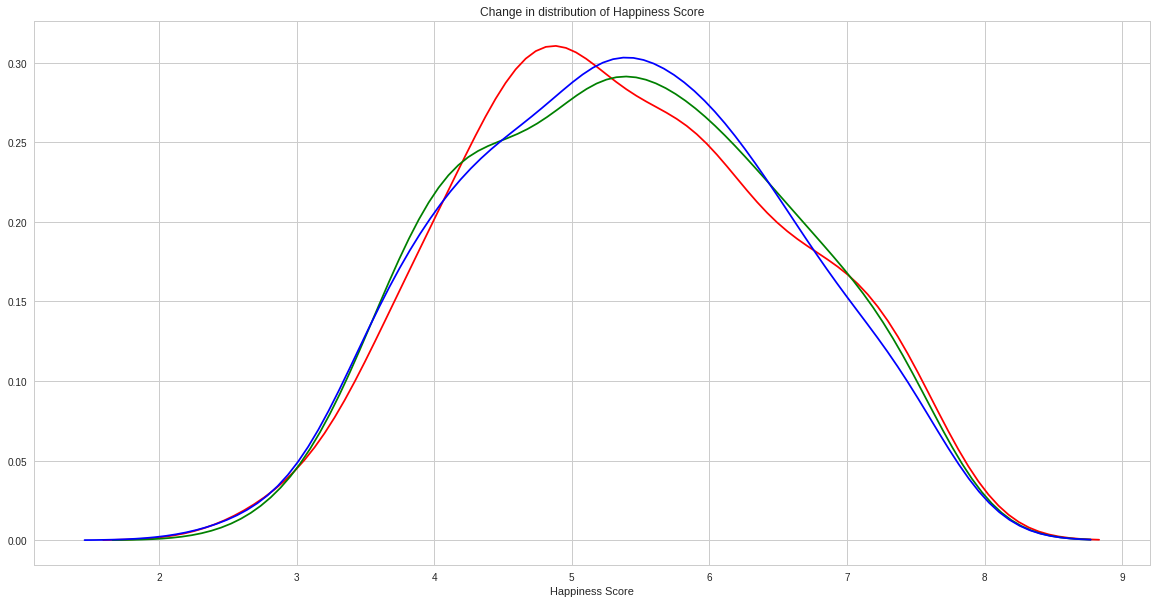

In [26]:
#overlap of distribution plots
comp = sns.distplot(data2015['happy'], kde=True, color = "r", hist = False)
comp = sns.distplot(data2016['happy'], kde=True, color = "g", hist = False)
comp = sns.distplot(data2017['happy'], kde=True, color = 'b', hist = False)
comp.set_xlabel('Happiness Score')
comp.set_title("Change in distribution of Happiness Score")
comp.legend()

In [27]:
#retrieve file from internet first time, then from os
if os.path.isfile("changeData.csv"):
    filepath = "changeData.csv"
    print "loading from file"
    changeData = pd.read_csv(filepath)
else:
    filepath = "http://worldhappiness.report/wp-content/uploads/sites/2/2017/03/online-data-chapter-2-whr-2017.xlsx"
    print "loading from the internet"
    xlsx_file = pd.read_excel(filepath, 'Figure2.3 WHR 2017')
    changeData = xlsx_file.to_csv('changeData.csv')
    changeData = pd.read_csv('changeData.csv')

print "done"

loading from file
done


In [28]:
changeData.head()

,Unnamed: 0,country,Changes in happiness scores,Whisker-high,Whisker-low
0,0,Nicaragua,1.364229,1.554066,1.174391
1,1,Latvia,1.162330,1.265406,1.059254
2,2,Sierra Leone,1.102750,1.277814,0.927686
3,3,Ecuador,0.998350,1.141503,0.855197
4,4,Moldova,0.898817,1.012292,0.785342


In [29]:
#change titles and filter unecessary information
changeData = changeData.rename(columns= {'Changes in happiness scores' : 'change'})
changeData = changeData.filter(['country', 'change'], axis = 1)
changeData.head()

,country,change
0,Nicaragua,1.364229
1,Latvia,1.162330
2,Sierra Leone,1.102750
3,Ecuador,0.998350
4,Moldova,0.898817


In [30]:
#create choropleth map of change in happiness
data = dict(type = 'choropleth', 
           locations = changeData['country'],
           locationmode = 'country names',
           z = changeData['change'],
           colorscale = [[0,"rgb(84, 39, 143)"], [0.35, "rgb(158, 154, 200)"], [0.6,"rgb(188, 189, 220)"], 
                        [0.7, "rgb(218, 218, 235)"], [1, "rgb(242,240,247)"]],
           text = changeData['country'],
           autocolorscale = False,
           colorbar = {'title':'Amount of Change'})

layout = dict(title = 'Change in the Happiness of Countries', 
                geo = dict(showframe = False, 
                       projection = {'type': 'Mercator'}))

globalMap = go.Figure(data = [data], layout=layout)
iplot(globalMap)

In [31]:
#bar plot of changing levels of happiness by Country
data = [go.Bar (
            x = changeData['change'],
            y = changeData['country'],
            orientation = 'h',
            marker = dict(
                color = "rgb(204,229,255)"
                
            )
)]

py.iplot(data, filename = 'horizontal-bar')

In [32]:
#filter for top and bottom 10
bottomTen = changeData.iloc[-10:]
topTen = changeData.iloc[:10]
topBottom = topTen.append(bottomTen)
topBottom

,country,change
0,Nicaragua,1.364229
1,Latvia,1.162330
2,Sierra Leone,1.102750
3,Ecuador,0.998350
4,Moldova,0.898817
5,Bulgaria,0.869859
6,Russia,0.845084
7,Slovakia,0.832859
8,Chile,0.773036
9,Uzbekistan,0.739035


In [35]:
#bar plot of top and bottom 10
data = [go.Bar (
            x = topBottom['change'],
            y = topBottom['country'],
            orientation = 'h',
            marker = dict(
                color = "rgb(204,229,255)"
                
            )
)]

layout = go.Layout(
    title = 'Change in Happiness // Top 10',
    xaxis = dict(
        title = 'Change in score'
    ),
    yaxis = dict(
        title = 'Country'
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(data, filename = 'horizontal-bar')

SyntaxError: invalid syntax (<ipython-input-34-9a955bebea50>, line 1)